# Nuking the Gradient

## Exploring why gradients explode with simple linear regression.

In this notebook, we're going to do simple linear regression with gradient descent using 1000 data points taken from a known distribution. 

Because we're generating the data, we already know the relationship between the `x`-values and the `y`-values:

$$y = 10 - x + \epsilon$$

where $\epsilon$ is randomly selected from the standard normal distribution (with $\mu = 0$ and $\sigma = 1$), so we're not interested in getting gradient descent to <i>work</i>. In fact, we're interested in the exact opposite: under what conditions will it <i>not</i> work? In other words, we're going to poke the algorithm until the gradient explodes.

## Some EDA, just to confirm the relationship.

Before diving into the gradient descent, I just want to show that the data is, in fact, very linear. First, a quick function for loading the data and returning it as an array of x-values and an array of y-values.

In [1]:
import pandas as pd
import random

def load_data():
    df = pd.read_csv('data.csv', names=['x', 'y'])
    return df.x, df.y

Next, let's look at the data with a scatterplot.

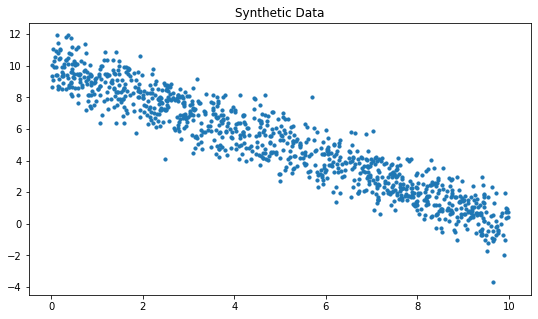

In [3]:
import matplotlib.pyplot as plt

x, y = load_data()
plt.figure(figsize=(9,5))
plt.scatter(x, y, s=10)
plt.title('Synthetic Data');

Okay, yeah, that's linear. That's super linear, actually. But just to make sure... let's compute the correlation coefficient and the formula of the least-squares regression line, juuuuust to be sure. And to respect the spirit of this post's DIY-ness, let's just go ahead do it all from scratch.

In [2]:
def mean(z):
    return sum(z) / len(z)

def std(z):
    zbar = mean(z)
    return (sum((zi - zbar)**2 for zi in z) / (len(z) - 1))**0.5

def compute_r(x, y):
    xbar = mean(x)
    ybar = mean(y)
    sx = std(x)
    sy = std(y)
    
    return sum((xi - xbar) * (yi - ybar) / (sx * sy) for xi, yi in zip(x,y)) / (len(x) - 1)

def least_squares_regression_line(x, y):
    r = compute_r(x, y)
    b = r * std(y) / std(x)
    m = mean(y) - b * mean(x)
    return m, b

x, y = load_data()
m, b = least_squares_regression_line(x,y)
print(compute_r(x, y))
print(f'y = {m}*x + {b}')

-0.9466500112761806
y = 10.061630757418902*x + -1.003707607875859


Okay! Strong negative correlation (r = -.95), and we basically got back the original line (with reasonable error) when we looked at the least-squares formula. So that means gradient descent will work <i>perfectly</i>... right?

Nope. Let's get to 'splodin.

## Stochastic Gradient Descent From Scratch

In order to understand how <a href="https://en.wikipedia.org/wiki/Stochastic_gradient_descent">Stochastic Gradient Descent (SGD)</a> goes wrong, we need to understand how it should, theoretically, go right.

If you are not familiar with SGD, it's a version of gradient descent which can be less computationally intensive because we don't need to compute the loss function or gradient for the entire dataset. We work with just one observation at a time.

### Definitions

Our <b>model</b>, which is the function we're trying to find that will represent the data, has the form $y = mx + b$

The <b>prediction</b> for an observation $(x_i, y_i)$ is $\hat{y_i} = mx_i + b$

The <b>loss function</b> we're using is $L(x_i, y_i) = (\hat{y_i} - y_i)^2 = (m)$

The <b>gradient of the loss function</b> consists of the partial derivatives of the loss function with respect to $m$ and $b$:

$$L_m(x_i, y_i) = \frac{\partial{L}}{\partial{m}} = 2x_i(mx_i + b - y_i) \quad \quad L_b(x_i, y_i) = \frac{\partial{L}}{\partial{b}} = 2(mx_i + b - y_i)$$

The <b>learning rate</b>, $\eta$ ("eta") is a multiplier, generally between 0 and 1.

1. Initialize $m$ and $b$ with arbitrary values. For reproducibility, these will not be random.
2. Randomly select an observation $(x_i, y_i)$ from the dataset.
3. Evaluate the partial derivatives (the gradient) at $(x_i, y_i)$: $L_m(x_i, y_i)$ and $L_b(x_i, y_i)$.
4. Update $m$ and $b$ as follows: $m := m - \eta L_m(x_i, y_i)$ and $b := b - \eta L_b(x_i, y_i)$
5. Repeat steps 2-4 until some halting criteria is met.

The halting criteria in Step 5 depends on the circumstances. It can be, "The algorithm has run through the data enough times for us," or "the change in the coefficients is smaller than some threshold value."

### Our Halting Criteria

Since my goal here is to nuke this gradient from orbit, we're going to initialize both values at 1

1. The values get close enough that we're happy with them. Let's just say that both $m$ and $b$ are within 1% of the actual value at the same time. That is, $9.9 < b < 10.1$ and $-1.01 < m < -.99$

2. The gradient explodes. Since m = -1 and b = 10, let's define "exploding" as the absolute value of either $m$ or $b$ exceeding a very large number (like 1000000000000). Whereas in the first case, we wanted both values to be pretty close at the same time, I'm willing to say, "If either the intercept or the slope gets so horrendously off-course that it could never possibly return to the right ballpark, let's call it a day."

## Building the Linear Model

I'm a big fan of keeping things simple and readable in the places where they matter, and I want to keep the meat of this process clean and tidy. That means we need to do some organizing before we actually get to the exploding gradient.

In order to keep the actual logic behind what we're doing as readable as possible, we'll take an object-oriented approach to this problem. This <em>is not intended</em> to be the most efficient solution to this problem, it isn't designed for use outside of this notebook (but feel free to, if you want to!), and it's completely for the sake of readability further down.

In [3]:
import random, math

class LinearModel:
    def __init__(self, m=None, b=None):
        """
        Initializes the slope and y-intercept of the regression line with either default values
        or the values that have been passed as arguments.
        
        Parameters
        ---------
        m (float):
            an initial value for the slope
        b (float):
            an initial value for the y-intercept
        """
        self.m = m or random.random()
        self.b = b or random.random()
        
        # after each iteration, we'll add a dictionary containing the current values of to 
        # the history object, e.g. {'m':11.5, 'b':-3.42, 'loss':.25, 'gradient':(-1.2, 3.5)}
        self.history = []
   
    def error(self, x=None, y=None):
        """
        Returns the error of the observation (x,y) passed, computed as
        self.
        
        Parameters
        ----------
        x (float):
            the x-value of the observation
        y (float):
            the y-value of the observation
        """
        return self.predict(x) - y
    
    def gradient(self, x, y):
        """
        Computes the gradient of the loss function at this observation, computed as
        
        (x * (mx+b - y), (mx+b - y))
        
        Parameters
        ----------
        x (float): 
            the x-value of the observation where we want the gradient
        y (float):
            the y-value of the observation where we want the gradient
            
        Return
        ------
        A list containing ∂L/∂m, ∂L/∂b
        """
        return x * self.error(x,y), self.error(x,y)
    
    def loss(self, x, y):
        """
        Computes the loss, which is (mx+b - y)^2
        
        Parameters
        ----------
        x (float):
            the x-value of the observation
        y (float):
            the y-value of the observation
        
        Returns
        -------
        The loss, (prediction-actual)^2 = (mx+b - y)**2
        """
        return self.error(x, y)**2
    
    def predict(self, x):
        """
        Accepts an x-value and returns the prediction, m*x + b
        
        Parameters
        ----------
        x (float):
            the x-value whose y-value we want to predict
        
        Returns
        -------
        the prediction mx + b with the current values of m and b
        """
        return self.m*x + self.b
    
    def rmse(self, xlist, ylist):
        """
        Computes the rmse for the data passed.
        
        Parameters
        ----------
        xlist (array-like):
            an array containing the x-values
        ylist (array-like):
            an array c
        """
        return math.sqrt(sum(list(self.loss(x,y) for x,y in zip(xlist, ylist)))) / len(xlist)
    
    
    
    def step(self, m_step, b_step):
        """
        Accepts a step for m and b, and adds those to their counterparts.
        
        Parameters
        ----------
        m_step (float):
            the amount to step along the m-axis
        b_step (float):
            the amount to step along the b-axis
        
        Returns
        -------
        None
        """
        self.m += m_step
        self.b += b_step
    
    def update_history(self, x=None, y=None, epoch=0, message=None, only_message=False):
        """
        Updates the object's history dictionary with a variety of possible values.
        
        Parameters
        ----------
        x (float):
            The x-value where the model will be evaluated
            Default: None
        y (float):
            The y-value where the model will be evaluated
            Default: None
        epoch (int):
            The current epoch during training.
            Default: 0
        message (str):
            A message to be added to history (e.g. for batch descent where there is 
                no point)
            Default: 
        only_message(bool):
            If True, only the message is added to history.
            Default: False
        
        Returns
        -------
        None
        """
        self.history.append({'m':self.m, 
                            'b':self.b, 
                            'observation':(x,y),
                            'prediction':self.predict(x),
                            'error':self.error(x,y),
                            'loss':self.loss(x,y),
                            'epoch':epoch,
                            'message':message})
    
    def __str__(self):
        """
        Returns a string containing the equation of the regression line.
        
        Returns
        -------
        A formatted linear equation.
        """
        return 'y = {:.3f}x + {:.3f}'.format(self.m, self.b)

Let's also go ahead and write functions for shuffling and splitting our data, while we're at it.

In [4]:
import random

def shuffle_data(list1, list2, seed=0):
    """
    Shuffle two lists of the same length with the same new order.
    Zips the lists together, to create a list of tuples, then shuffles the list of tuples. 
    Splits the shuffled list of tuples back into individual tuples, then zips the coordinates
    back into separate lists.
    
    Parameters
    ----------
    list1 (list-like):
        a list of values to shuffle
    list2 (list-like):
        a list of values to shuffle
    
    Returns
    -------
    Two lists, shuffled in the same way.
    """
    # z
    zipped = list(zip(list1, list2))
    random.seed(seed)
    random.shuffle(zipped)
    return list(zip(*zipped))

def train_test_split(x, y, test_size=0.2, seed=0):
    """
    Splits data into training and test sets.
    Shuffles the data, then takes the first (100 * test_size)% items as test data and
    the remaining items as training data.
    
    Parameters
    ----------
    x (array-like):
        The x-values of the data points
    y (array-like):
        The y-values of the data points
    test_size (float):
        Proportion of values to include in the test set.
        Default: 0.2
    seed (int):
        A seed for the random class.
        Default: 0
        
    Returns
    -------
    x_train, x_test, y_train, y_test
    """
    break_index = int(0.2 * len(x))
    shuffled_x, shuffled_y = shuffle_data(x, y, seed)
    return shuffled_x[break_index:], shuffled_x[:break_index], shuffled_y[break_index:], shuffled_y[:break_index]

Okay! Now that we've got a class to make things readable, we can jump into Stochastic Gradient Descent (SGD).

In [72]:
import tqdm
from linear_model import LinearModel

def stochastic_gradient_descent(x_values=None, 
                                y_values=None, 
                                num_epochs=10, 
                                learning_rate=0.001, 
                                initial_m=None,
                                initial_b=None,
                                true_m=-1,
                                true_b=1,
                                threshold_m=1,
                                threshold_b=1,
                                seed=None):
    """
    Implements SGD for linear regression on the dataset. Returns a LinearModel object
    that has exploded, converged, or trained for the expected amount of time.
    
    Parameters
    ----------
    x_values (array-like):
        An array of x-values
    y_values (array-like):
        An array of y-values
    num_epochs (int): 
        The number of times to expose the model to the dataset.
        Default: 10
    learning_rate (float):
        A factor to scale the gradient in the right direction.
        Default: 0.001
    initial_m (float):
        An initial value for the slope, before training.
    initial_b (float):
        An initial value for the intercept, before training.
    true_m (float):
        The true slope of the data.
        Default: -1 (for data.csv)
    true_b (float):
        The true intercept of the data.
        Default: 10 (for data.csv)
    seed (int):
        A seed for the random function. If no seed is provided, no seed is used.
    
    Returns
    -------
    A fitted LinearModel object, for better or worse.
    """
       
    if seed:
        random.seed(seed)
    model = LinearModel(initial_m, initial_b)
    
    try:
        for epoch in tqdm.trange(1, num_epochs+1):
            # shuffle the observations for this epoch (so model encounters points randomly)
            x_shuff, y_shuff = shuffle_data(x_values, y_values)
        

            # iterate over the entire shuffled dataset
            for x, y in zip(x_shuff, y_shuff):
                # compute the gradient for this observation
                m_gradient, b_gradient = model.gradient(x,y)

                # update the model by stepping in the negative direction of the gradient
                # stepsize is -gradient * learning_rate (negative is for descent)
                model.step(-learning_rate*m_gradient, -learning_rate*b_gradient)
                
                model.update_history(x,y)

                # the model has converged
                if abs(model.m - true_m) < threshold_m and abs(model.b - true_b) < threshold_b:
                    print('Returning model early due to convergence.')
                    return model
    except OverflowError:
        print('Returning model early due to explosion.')
        return model
    
    print('Model did not converge or explode. Finished training.')
    return model
        
x, y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y)
model = stochastic_gradient_descent(num_epochs=100,
                                    learning_rate=.1,
                                    x_values=x_train, 
                                    y_values=y_train, 
                                    initial_m=1, 
                                    initial_b=1,
                                    true_m=-1,
                                    true_b=10,
                                    threshold_m=0.01,
                                    threshold_b=0.1,
                                    seed=0)

print('Model:', model)

  0%|          | 0/100 [00:00<?, ?it/s]

Returning model early due to explosion.
Model: y = 2129540374733057965131681914694300327389372243695572421081896632310351398284587934267594552433602270131232797348558719906285696110154186996030684098723840.000x + 281985276213158382110789551250111840908527506144309150450958069157586309145519842272640307126365618851778003250914139217202912912688770295525995089756160.000


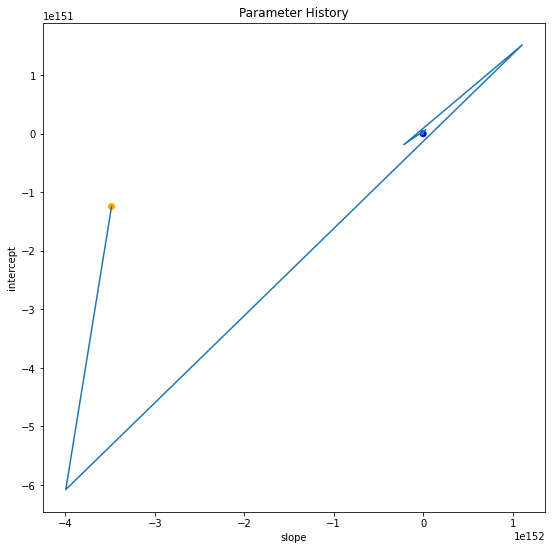

In [73]:
import tqdm
import matplotlib.pyplot as plt

def plot_history(model):
    ms = [step['m'] for step in model.history]
    bs = [step['b'] for step in model.history]

    plt.figure(figsize=(9,9))
    plt.scatter([ms[0], ms[-1]], [bs[0], bs[-1]], c=['blue', 'orange'])
    plt.plot(ms, bs);
    plt.xlabel('slope')
    plt.ylabel('intercept')
    plt.title('Parameter History');
    
plot_history(model)

In [74]:
len(model.history)

723

In [75]:
len(x_test)

200

This raises the question: Why does the gradient explode like this?

To answer this question, let's examine the points we encounter before the values of these parameters go off the chart, then step through the calculations to see where we went wrong.

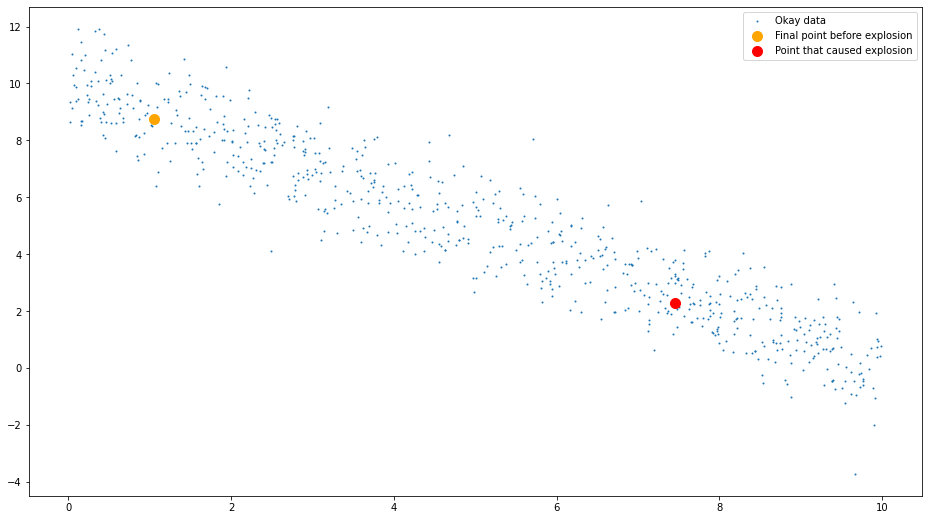

In [86]:
points_evaluated = [obs['observation'] for obs in model.history]
xs = [p[0] for p in points_evaluated]
ys = [p[1] for p in points_evaluated]

next_x = x_train[len(xs)]
next_y = y_train[len(ys)]

plt.figure(figsize=(16,9))
plt.scatter(xs, ys, s=1)
plt.scatter([xs[-1]], [ys[-1]], c='orange', s=100)
plt.scatter([next_x], [next_y], c='red', s=100);
plt.legend(['Okay data', 'Final point before explosion', 'Point that caused explosion'])

In [45]:
from linear_model import LinearModel
import tqdm

def batch_gradient_descent(x_values=None, 
                           y_values=None,
                           num_epochs=10, 
                           learning_rate=0.001, 
                           initial_m=None,
                           initial_b=None,
                           true_m=-1, true_b=10, 
                           threshold_m=1,
                           threshold_b=1,
                           seed=None):
    """
    Implements batch gradient descent for linear regression on the dataset. Returns a 
    LinearModel object that has exploded, converged, or trained for the expected amount 
    of time.
    
    Parameters
    ----------
    x_values (array-like):
        An array of x-values
    y_values (array-like):
        An array of y-values
    num_epochs (int): 
        The number of times to expose the model to the dataset.
        Default: 10
    learning_rate (float):
        A factor to scale the gradient in the right direction.
        Default: 0.001
    initial_m (float):
        An initial value for the slope, before training.
    initial_b (float):
        An initial value for the intercept, before training.
    true_m (float):
        The true slope of the data.
        Default: -1 (for data.csv)
    true_b (float):
        The true intercept of the data.
        Default: 10 (for data.csv)
    seed (int):
        A seed for the random function. If no seed is provided, no seed is used.
    
    Returns
    -------
    A fitted LinearModel object, for better or worse.
    """
    
    if seed:
        random.seed(seed)

    model = LinearModel(initial_m, initial_b)

    try:
        # iterate over the entire dataset a specific number of times
        for epoch in tqdm.trange(1, num_epochs + 1):
            m_grad = 0
            b_grad = 0

            # since we're working with the mean gradient, we don't need to shuffle the
            # points during training
            for x, y in zip(x_values, y_values):
                # compute the gradients for this point
                m_grad += model.gradient(x, y)[0]
                b_grad += model.gradient(x, y)[1]
                
                # update history
                model.update_history(x, y, epoch)

            # compute the mean gradients from the sum
            m_grad /= len(x_values)
            b_grad /= len(y_values)

            # take our step in the right direction
            model.step(-learning_rate * m_grad, -learning_rate * b_grad)
            
            # if we're close enough, stop
            if abs(model.m - true_m) < threshold_m and abs(model.b - true_b) < threshold_b:
                print('Returning model early due to convergence.')
                return model
    
    # if the gradient explodes
    except OverflowError:
        print('Returning model early due to explosion.')
        return model
    
    # otherwise, we made it to the end!
    print('Model did not converge or explode. Finished training.')
    return model

x, y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x,y)
model = batch_gradient_descent(num_epochs=1000,
                               learning_rate=.1,
                               x_values=x_train, 
                               y_values=y_train, 
                               initial_m=1, 
                               initial_b=1,
                               true_m=-1,
                               true_b=10,
                               threshold_m=0.01,
                               threshold_b=0.1,
                               seed=0)
print(model)

 39%|███▉      | 392/1000 [00:01<00:02, 220.25it/s]


Returning model early due to explosion.
y = 1983460044143932903188201589697410216439254431351906571633363866266737430018483345174755783891064298267078491026444317544724931423859008900971434514317312.000x + 296529782452845290810000553292315652137000591720758675880863004057699841058018695569310246780659594662123846049388086555820545276892743268226836474101760.000


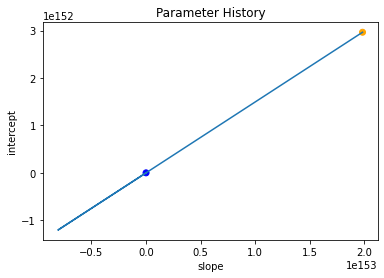

In [46]:
import tqdm
import matplotlib.pyplot as plt

def plot_history(model):
    ms = [step['m'] for step in model.history]
    bs = [step['b'] for step in model.history]

    plt.scatter([ms[0], ms[-1]], [bs[0], bs[-1]], c=['blue', 'orange'])
    plt.plot(ms, bs);
    plt.xlabel('slope')
    plt.ylabel('intercept')
    plt.title('Parameter History');

In [40]:
m_subset = ms[::int(len(ms)/100)]
b_subset = bs[::int(len(bs)/100)]

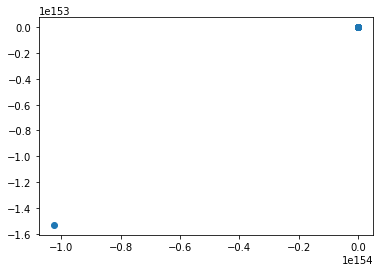

In [41]:
import matplotlib.pyplot as plt

plt.scatter(m_subset, b_subset)

2.9078389860125475

In [84]:
from linear_model import LinearModel
import tqdm

def minibatch_gradient_descent(x_values=None, 
                               y_values=None,
                               batch_size=1,
                               num_epochs=10, 
                               learning_rate=0.001, 
                               initial_m=None,
                               initial_b=None,
                               true_m=-1, true_b=10, 
                               threshold_m=1,
                               threshold_b=1,
                               seed=None):
    """
    Implements minibatch gradient descent for linear regression on the dataset. Returns a 
    LinearModel object that has exploded, converged, or trained for the expected amount 
    of time.
    
    Parameters
    ----------
    x_values (array-like):
        An array of x-values
    y_values (array-like):
        An array of y-values
    batch_size (int):
        The batch size to use.
    num_epochs (int): 
        The number of times to expose the model to the dataset.
        Default: 10
    learning_rate (float):
        A factor to scale the gradient in the right direction.
        Default: 0.001
    initial_m (float):
        An initial value for the slope, before training.
    initial_b (float):
        An initial value for the intercept, before training.
    true_m (float):
        The true slope of the data.
        Default: -1 (for data.csv)
    true_b (float):
        The true intercept of the data.
        Default: 10 (for data.csv)
    seed (int):
        A seed for the random function. If no seed is provided, no seed is used.
    
    Returns
    -------
    A fitted LinearModel object, for better or worse.
    """
    
    if seed:
        random.seed(seed)
        
    model = LinearModel(1,1)

    try:
        for epoch in tqdm.trange(1, num_epochs+1):
            
            # shuffle the data
            x_shuff, y_shuff = shuffle_data(x_values, y_values)
            
            # zip it together once so we can use it in the loop
            obs_shuff = list(zip(x_shuff, y_shuff))

            index = 0

            while index < len(x_shuff):
                # set the gradients equal to zero
                m_grad = 0
                b_grad = 0

                for x, y in obs_shuff[index:index+batch_size]:
                    m_grad += model.gradient(x, y)[0]
                    b_grad += model.gradient(x, y)[1]
                    model.update_history(x,y)

                m_grad /= min(batch_size, len(obs_shuff)-index)
                b_grad /= min(batch_size, len(obs_shuff)-index)

                model.step(-learning_rate * m_grad, -learning_rate * b_grad)
                index += batch_size

            # if we're close enough, stop
            if abs(model.m - true_m) < threshold_m and abs(model.b - true_b) < threshold_b:
                    print('Returning model early due to convergence.')
                    return model
    
    # if the gradient explodes
    except OverflowError:
        print('Returning model early due to explosion.')
        return model
    
    # otherwise, we made it to the end!
    print('Model did not converge or explode. Finished training.')
    return model
    
x, y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x,y)
model = minibatch_gradient_descent(num_epochs=1000,
                                   batch_size=100,
                                   learning_rate=.0001,
                                   x_values=x_train, 
                                   y_values=y_train, 
                                   initial_m=1, 
                                   initial_b=10,
                                   true_m=-1,
                                   true_b=10,
                                   threshold_m=0.01,
                                   threshold_b=0.1,
                                   seed=0)
print(model)

100%|██████████| 1000/1000 [00:05<00:00, 182.16it/s]


Model did not converge or explode. Finished training.
y = 0.118x + 2.546


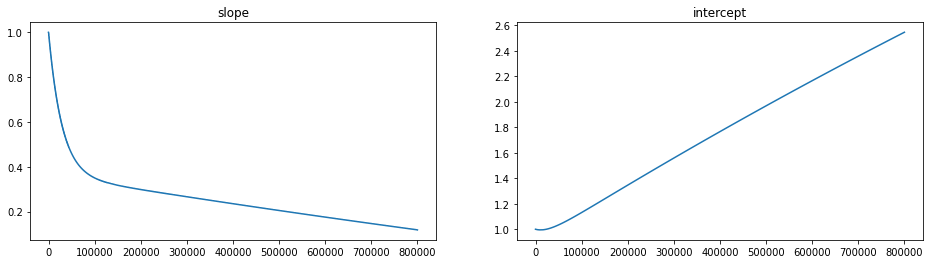

In [85]:
ms = [obs['m'] for obs in model.history]
bs = [obs['b'] for obs in model.history]

import matplotlib.pyplot as plt
fig, (m_ax, b_ax) = plt.subplots(1,2, figsize=(16,4))
m_ax.plot(ms)
m_ax.set_title("slope")
b_ax.plot(bs)
b_ax.set_title("intercept")
plt.show()